<a href="https://colab.research.google.com/github/kartik04041/AI-powered-Resume-Builder/blob/main/Website%20traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===== KEY METRICS =====
Total Users: 3839
Total Sessions: 6563
Bounce Rate: 28.55%
Average Session Duration (seconds): 0.00


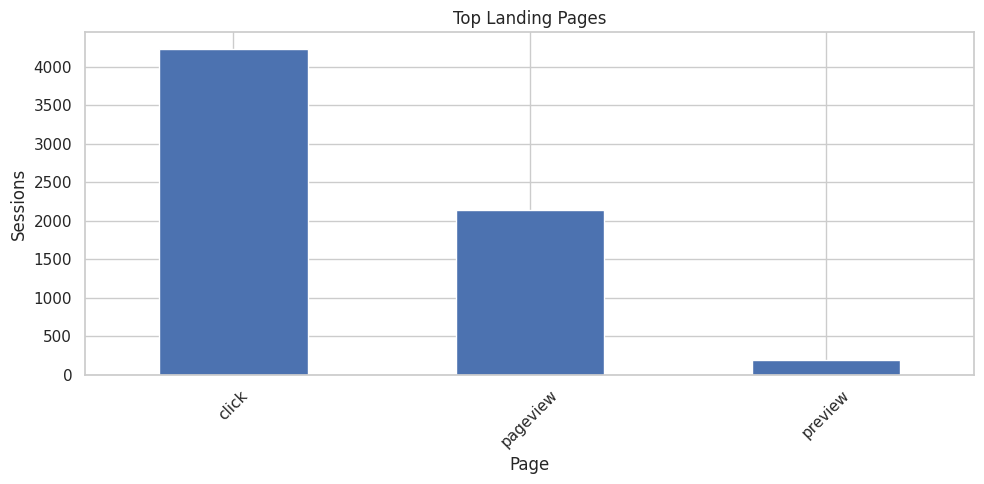

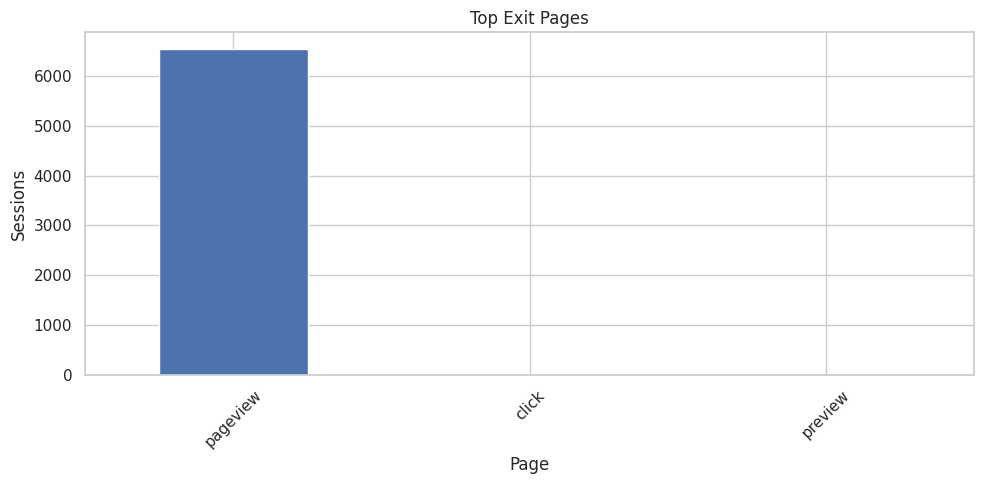

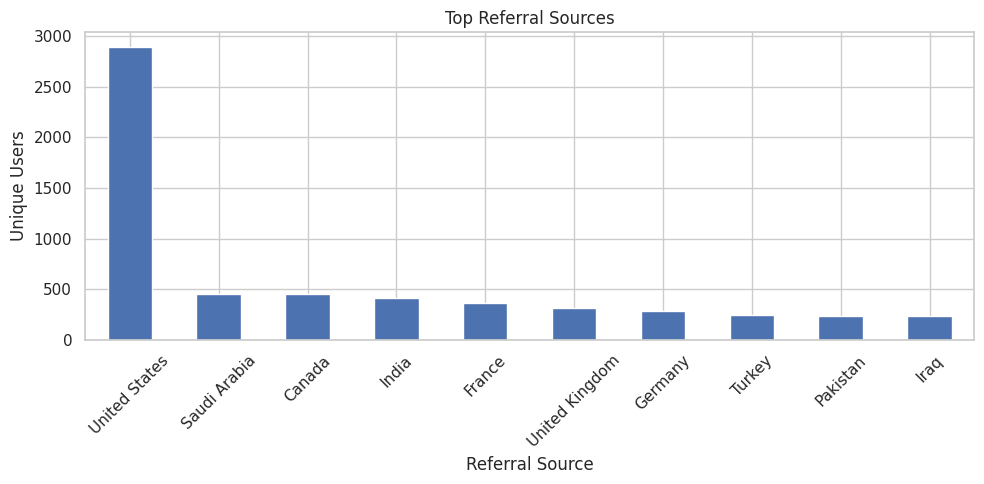


Top Page Transitions:
       page next_page  count
3  pageview  pageview  66721
0     click     click  27962
7   preview   preview  14400
1     click  pageview   2493
2     click   preview   2036
6   preview  pageview   2009
5   preview     click    298
4  pageview   preview     85


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("traffic.csv")

df.rename(columns={
    'linkid': 'user_id',
    'event': 'page',
    'date': 'timestamp',
    'country': 'referral_source'
}, inplace=True)

df.drop_duplicates(inplace=True)
df.dropna(subset=['user_id', 'page', 'timestamp'], inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(['user_id', 'timestamp'], inplace=True)

df['time_diff'] = df.groupby('user_id')['timestamp'].diff()
df['new_session'] = (df['time_diff'] > pd.Timedelta(minutes=30)) | (df['time_diff'].isna())
df['session_id'] = df.groupby('user_id')['new_session'].cumsum()

total_users = df['user_id'].nunique()
total_sessions = df.groupby(['user_id', 'session_id']).ngroups

session_counts = df.groupby(['user_id', 'session_id']).size().reset_index(name='page_count')
single_page_sessions = session_counts[session_counts['page_count'] == 1].shape[0]
bounce_rate = (single_page_sessions / total_sessions) * 100

session_duration = df.groupby(['user_id', 'session_id'])['timestamp'].agg(['min','max'])
session_duration['duration'] = (session_duration['max'] - session_duration['min']).dt.total_seconds()
avg_session_duration = session_duration['duration'].mean()

print("===== KEY METRICS =====")
print("Total Users:", total_users)
print("Total Sessions:", total_sessions)
print("Bounce Rate: {:.2f}%".format(bounce_rate))
print("Average Session Duration (seconds): {:.2f}".format(avg_session_duration))

landing_pages = df.groupby(['user_id','session_id']).first()['page']
exit_pages = df.groupby(['user_id','session_id']).last()['page']

top_landing = landing_pages.value_counts().head(10)
top_exit = exit_pages.value_counts().head(10)

referral_analysis = df.groupby('referral_source')['user_id'].nunique().sort_values(ascending=False)

plt.figure()
top_landing.plot(kind='bar')
plt.title("Top Landing Pages")
plt.xlabel("Page")
plt.ylabel("Sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
top_exit.plot(kind='bar')
plt.title("Top Exit Pages")
plt.xlabel("Page")
plt.ylabel("Sessions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
referral_analysis.head(10).plot(kind='bar')
plt.title("Top Referral Sources")
plt.xlabel("Referral Source")
plt.ylabel("Unique Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df['next_page'] = df.groupby(['user_id','session_id'])['page'].shift(-1)
transitions = df.dropna(subset=['next_page'])
flow = transitions.groupby(['page','next_page']).size().reset_index(name='count')
print("\nTop Page Transitions:")
print(flow.sort_values('count', ascending=False).head(10))

